In [1]:
# hide
# default_exp core.compose
from nbdev.showdoc import *
from block_types.utils.nbdev_utils import nbdev_setup, TestRunner

nbdev_setup ()
tst = TestRunner (targets=['dummy'])

# Compose components

> Classes and utilities for composed components

In [2]:
#export
import warnings
import sys
from pathlib import Path
from sklearn.utils import Bunch
import pandas as pd

try:
    from graphviz import *
    imported_graphviz = True
except:
    imported_graphviz = False

from block_types.core.block_types import (Component, 
                                          PandasComponent, 
                                          SamplingComponent,
                                          NoSaverComponent)
from block_types.core.data_conversion import PandasConverter
from block_types.core.utils import PandasIO
from block_types.utils.utils import get_logging_level, set_empty_logger
import block_types.config.bt_defaults as dflt

In [3]:
#for tests
from pathlib import Path
import pytest 
import time
import numpy as np
import os
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.utils import Bunch

from block_types.core.block_types import PickleSaverComponent
from block_types.utils.utils import remove_previous_results, set_empty_logger
from block_types.core.utils import PickleIO
from block_types.utils.utils import check_last_part

In [4]:
# for tests
import joblib

## MultiComponent

In [5]:
#export
class MultiComponent (SamplingComponent):
    """
    Component containing a list of components inside.
    
    The list must contain at least one component. 
    
    See `Pipeline` class.
    """
    def __init__ (self, 
                  *components,
                  separate_labels=dflt.separate_labels, 
                  warning_if_nick_name_exists=dflt.warning_if_nick_name_exists,
                  propagate=dflt.propagate,
                  path_results=dflt.path_results,
                  path_models=dflt.path_models,
                  **kwargs):
        """Assigns attributes and calls parent constructor.

        Parameters
        ----------
        separate_labels: bool, optional
            whether or not the fit method receives the labels in a separate `y` vector 
            or in the same input `X`, as an additional variable. See description of 
            Pipeline class for more details.
        """
        if 'estimator' in kwargs:
            self.logger.warning ('estimator passed as key-word argument in MultiComponent')
        
        self.warning_if_nick_name_exists = warning_if_nick_name_exists
        
        if len(components) > 0:
            self.set_components (*components)
        elif not hasattr (self, 'components'):
            self.components = []
        if not hasattr (self, 'finalized_component_list'):
            self.finalized_component_list = False
        
        
        # we need to call super().__init__() *after* having creating the `components` field,
        # since the constructor of Component calls a method that is overriden in Pipeline, 
        # and this method makes use of the mentioned `components` field
        super().__init__ (separate_labels=separate_labels, path_results=path_results, path_models=path_models,
                          **kwargs)

        self.set_split ('whole')
        
        self.chain_folders (self.data_io.folder)
        if self.propagate: 
            self.set_path_results (self.path_results)
            self.set_path_models (self.path_models)
        
        self.start_idx = dict (apply = dict (training=0, validation=0, test=0, whole=0),
                               fit = dict (training=0, validation=0, test=0, whole=0))
        self.is_data_source = dict (apply = dict (training=False, validation=False, test=False, whole=False),
                               fit = dict (training=False, validation=False, test=False, whole=False))
        
    
    def register_components (self, *components):
        """
        Registering component in `self.components` list.
        
        Every time that a new component is set as an attribute of the pipeline,
        this component is added to the list `self.components`. Same 
        mechanism as the one used by pytorch's `nn.Module`
        """
        if not hasattr(self, 'components'):
            self.components = []
            self.finalized_component_list = False
        if not self.finalized_component_list:
            self.components += components
            
    def _add_named_attribute (self, component, nick_name):
        if not hasattr(self, 'finalized_component_list'):
            self.finalized_component_list = False
        if not hasattr(self, component.name):
            super().__setattr__(component.name, component)
        if not self.finalized_component_list:
            if hasattr(component, 'nick_name') and self.warning_if_nick_name_exists:
                self.logger.warning (f'{component} already has a nick_name: {component.nick_name}')
                warnings.warn (f'{component} already has a nick_name: {component.nick_name}')
            component.nick_name = nick_name
    
    def __setattr__(self, k, v):
        """
        See register_components
        """
        super().__setattr__(k, v)
        
        if isinstance(v, Component):
            self.register_components(v)
            self._add_named_attribute (v, k)
            
    def add_component (self, component):
        if not hasattr(self, 'finalized_component_list'):
            self.finalized_component_list = False
        finalized_component_list = self.finalized_component_list
        self.finalized_component_list = False
        self.register_components(component)
        self._add_named_attribute (component, component.name)
        self.finalized_component_list = finalized_component_list
        
    def set_components (self, *components):
        self.components = components
        for component in components:
            self._add_named_attribute (component, component.name)
        self.finalized_component_list = True
        
    def clear_descendants (self):
        self.cls = Bunch ()
        self.obj = Bunch ()
        self.full_obj = Bunch ()
        self.full_cls = Bunch ()
        for component in self.components:
            if isinstance(component, MultiComponent):
                component.clear_descendants ()
            
    def gather_descendants (self, root='', nick_name=True):
        if not hasattr (self, 'cls'):
            self.cls = Bunch ()
            self.obj = Bunch ()
            self.full_obj = Bunch ()
            self.full_cls = Bunch ()
            
        if hasattr(self, 'nick_name'):
            name = self.nick_name if nick_name else self.name
        else:
            name = self.name
        self.hierarchy_path = f'{root}{name}'
        for component in self.components:
            self._insert_descendant (self.cls, component, component.class_name)
            self._insert_descendant (self.obj, component, component.name)
            
            name = component.nick_name if nick_name else component.name
            component_hierarchy_path = f'{self.hierarchy_path}.{name}'
            self._insert_descendant (self.full_cls, component_hierarchy_path, component.class_name)
            self._insert_descendant (self.full_obj, component_hierarchy_path, component.name)
            if isinstance(component, MultiComponent):
                component.gather_descendants (root=f'{self.hierarchy_path}.',
                                              nick_name=nick_name)
                for name in component.cls:
                    self._insert_descendant (self.cls, component.cls[name], name)
                    self._insert_descendant (self.full_cls, component.full_cls[name], name)
                for name in component.obj:
                    self._insert_descendant (self.obj, component.obj[name], name)
                    self._insert_descendant (self.full_obj, component.full_obj[name], name)
                           
    def _insert_descendant (self, cmp_dict, component, name):
        if name in cmp_dict:
            if not isinstance(cmp_dict[name], list):
                cmp_dict[name] = [cmp_dict[name]]
            if isinstance(component, list):
                cmp_dict[name].extend(component)
            else:
                cmp_dict[name].append(component)
        else:
            if isinstance(component, list):
                cmp_dict[name] = component.copy()
            else:
                cmp_dict[name] = component
                
    def gather_times (self):
        dfs = [self.profiler.retrieve_times ()]
        for component in self.components:
            if isinstance(component, MultiComponent):
                dfs.append(component.gather_times ())
            else:
                dfs.append(component.profiler.retrieve_times (is_leaf=True))
        dfs = self.profiler.combine_times (dfs)
        return dfs
        
    def construct_diagram (self, split=None, include_url=False, port=4000, project='block_types'):
        """
        Construct diagram of the pipeline components, data flow and dimensionality.
        
        By default, we use test data to show the number of observations 
        in the output of each component. This can be changed passing 
        `split='train'`
        """
        split = self.get_split (split)

        if include_url:
            base_url = f'http://localhost:{port}/{project}'
        else:
            URL = ''

        node_name = 'data'
        output = 'train / test'

        f = Digraph('G', filename='fsm2.svg')
        f.attr('node', shape='circle')

        f.node(node_name)

        f.attr('node', shape='box')
        for component in self.components:
            last_node_name = node_name
            last_output = output
            node_name = component.model_plotter.get_node_name()
            if include_url:
                URL = f'{base_url}/{component.model_plotter.get_module_path()}.html#{node_name}'
            f.node(node_name, URL=URL)
            f.edge(last_node_name, node_name, label=last_output)
            output = component.model_plotter.get_edge_name(split=split)

        last_node_name = node_name
        node_name = 'output'
        f.attr('node', shape='circle')
        f.edge(last_node_name, node_name, label=output)

        return f

    def show_result_statistics (self, split=None):
        """
        Show statistics about results obtained by each component. 
        
        By default, this is shown on test data, although this can change setting 
        `split='train'`
        """
        split = self.get_split (split)

        for component in self.components:
            component.show_result_statistics(split=split)

    def show_summary (self, split=None, file=sys.stdout):
        """
        Show list of pipeline components, data flow and dimensionality.
        
        By default, we use test data to show the number of observations 
        in the output of each component. This can be changed passing 
        `split='train'`
        """
        split = self.get_split (split)

        node_name = 'data'
        output = 'train / test'
        if isinstance (file, str) or isinstance (file, Path): file = open (file, 'wt')

        for i, component in enumerate(self.components):
            node_name = component.model_plotter.get_node_name()
            output = component.model_plotter.get_edge_name(split=split)
            print (f'{"-"*100}', file=file)
            print (f'{i}: {node_name} => {output}', file=file)


    def get_split (self, split=None):
        if split is None:
            if self.data_io.split is not None:
                split = self.data_io.split
            else:
                split = 'whole'

        return split

    def assert_all_equal (self, path_reference_results, raise_error=False, recursive=True, 
                          max_recursion=None, current_recursion=0, verbose=None, **kwargs):
        """Compare results stored in current run against reference results stored in given path."""
        if verbose is not None:
            self.logger.setLevel(get_logging_level (verbose))
        is_equal = True
        non_equal_components = []
        end_recursion = max_recursion is not None and current_recursion >= max_recursion
        components = self.components if not end_recursion else [self]
        for component in components:
            if isinstance(component, MultiComponent) and recursive and not end_recursion:
                this_equal = component.assert_all_equal (path_reference_results, 
                                                         raise_error=raise_error, 
                                                         recursive=recursive, 
                                                         max_recursion=max_recursion,
                                                         current_recursion=current_recursion+1,
                                                         verbose=verbose,
                                                         **kwargs) 
            else:
                this_equal = component.assert_equal (path_reference_results, 
                                                     raise_error=raise_error,
                                                     verbose=verbose,
                                                     **kwargs) 
            if not this_equal:
                non_equal_components.append(component.name)
            is_equal = this_equal and is_equal
            
        if not is_equal:
            self.logger.warning (f'Results are different in components {non_equal_components}')
        else:
            self.logger.info ('both pipelines give the same results')
        
        self.logger.setLevel(get_logging_level (self.verbose))
        
        return is_equal
        
    def load_estimator (self):
        for component in self.components:
            component.load_estimator ()
            
    def save_result (self, result, split=None, path_results=None, result_file_name=None):
        raise NotImplementedError ()
        self.data_io.save_result (result, split=split, path_results=path_results, 
                                  result_file_name=result_file_name)
        for component in self.components:
            if isinstance (component, MultiComponent):
                component.save_result (result, split=split, path_results=path_results, 
                                       result_file_name=result_file_name)
            else:
                component.data_io.save_result (result, split=split, path_results=path_results, 
                                               result_file_name=result_file_name)
    # *************************
    # setters
    # *************************
    def set_split (self, split):
        super().set_split (split)
        for component in self.components:
            component.set_split (split)

    def set_save_splits (self, save_splits):
        super().set_save_splits (save_splits)
        for component in self.components:
            component.set_save_splits (save_splits)
            
    def set_load_model (self, load_model):
        super().set_load_model (load_model)
        for component in self.components:
            component.set_load_model (load_model)

    def set_save_model (self, save_model):
        super().set_save_model (save_model)
        for component in self.components:
            component.set_save_model (save_model)
            
    def set_save_result (self, save_result):
        super().set_save_result (save_result)
        for component in self.components:
            component.set_save_result (save_result)
            
    def set_load_result (self, load_result):
        super().set_load_result (load_result)
        for component in self.components:
            component.set_load_result (load_result)
            
    def set_path_results (self, path_results):
        self.data_io.set_path_results (path_results)
        for component in self.components:
            if not component.data_io.stop_propagation:
                if isinstance (component, MultiComponent):
                    component.set_path_results (path_results)
                else:
                    component.data_io.set_path_results (path_results)
    def set_path_models (self, path_models):
        self.data_io.set_path_models (path_models)
        for component in self.components:
            if isinstance (component, MultiComponent):
                component.set_path_models (path_models)
            else:
                component.data_io.set_path_models (path_models)
    def chain_folders (self, folder, root=True):
        if folder == '':
            return
        if root:
            self.data_io.chain_folders ('')
        else:
            self.data_io.chain_folders (folder)
        for component in self.components:
            if isinstance (component, MultiComponent):
                component.chain_folders (folder, root=False)
            else:
                component.data_io.chain_folders (folder)
    
    def find_last_result (self, split=None):
        return False
        

### Usage examples / tests

#### MultiComponent example

In [6]:
# exports tests.core.test_compose
class SimpleMultiComponent (MultiComponent):
    def __init__ (self, **kwargs):
        data_io = PickleIO (**kwargs)
        super().__init__(data_io=data_io,
                         **kwargs)

        self.tr1 = Component(FunctionTransformer (lambda x: x*3),
                             data_io=data_io,
                             name='tr1')
        self.tr2 = Component(FunctionTransformer (lambda x: x*2),
                             data_io=data_io,
                             name='tr2')

    def _apply (self, X):
        return self.tr1 (X) + self.tr2(X)

#### Loading / saving all results

In [7]:
# exports tests.core.test_compose
#@pytest.mark.reference_fails
def test_multi_comp_io ():
    path_results = 'multi_component_loading_saving'
    remove_previous_results (path_results=path_results)

    X = np.array([1,2,3])
    composition1 = SimpleMultiComponent (path_results=path_results)
    result1 = composition1 (X)

    composition2 = SimpleMultiComponent (path_results=path_results)
    result2 = composition2.data_io.load_result()
    assert (result1==result2).all()

    resut_tr1_2 = composition2.tr1.data_io.load_result()
    resut_tr2_2 = composition2.tr2.data_io.load_result()
    assert (resut_tr1_2==composition1.tr1(X)).all()
    assert (resut_tr2_2==composition1.tr2(X)).all()

    assert sorted(os.listdir (f'{path_results}/whole'))==['simple_multi_component_result.pk', 'tr1_result.pk', 'tr2_result.pk']

    composition1.set_split ('validation')
    result1b = composition1 (X)
    assert sorted(os.listdir (f'{path_results}/validation'))==['simple_multi_component_result.pk', 'tr1_result.pk', 'tr2_result.pk']

    remove_previous_results (path_results=f'{path_results}/whole')

    resut_tr1_2 = composition2.tr1.data_io.load_result(split='validation')
    resut_tr2_2 = composition2.tr2.data_io.load_result()

    assert (resut_tr1_2==composition1.tr1(X)).all()
    assert resut_tr2_2 is None

    composition2.set_split('validation')
    resut_tr1_2 = composition2.tr1.data_io.load_result()
    resut_tr2_2 = composition2.tr2.data_io.load_result()

    assert (resut_tr1_2==composition1.tr1(X)).all()
    assert (resut_tr2_2==composition1.tr2(X)).all()

    remove_previous_results (path_results=path_results)

In [8]:
tst.run (test_multi_comp_io, tag='dummy', debug=False)

running test_multi_comp_io


#### Getting descendants

In [9]:
# exports tests.core.test_compose
#@pytest.mark.reference_fails
def test_multi_comp_desc ():
    class Intermediate (MultiComponent):
        def __init__ (self, name=None, **kwargs):
            super().__init__ (name=name, **kwargs)
            self.first = Component (name='first_component', **kwargs)
            self.second = Component (name='second_component', **kwargs)

    class Higher (MultiComponent):
        def __init__ (self, **kwargs):
            super().__init__ (**kwargs)
            self.first = Intermediate (name='first_intermediate', **kwargs)
            self.second = Intermediate (name='second_intermediate', **kwargs)
            self.gather_descendants(nick_name=False)

    higher = Higher()

    assert sorted(higher.obj.keys())==['first_component', 'first_intermediate', 'second_component', 'second_intermediate']

    # check types
    types = map(lambda x: type(x[1]), sorted(higher.obj.items()))
    assert list(types)==[list, Intermediate, list, Intermediate]

    sorted_list = list(sorted(higher.obj.items()))
    types = map(type, sorted_list[0][1])
    assert list(types)==[Component,Component]

    sorted_list = list(sorted(higher.obj.items()))
    types = map(type, sorted_list[2][1])
    assert list(types)==[Component,Component]

    sorted_keys=list(sorted(higher.cls.keys()))
    assert sorted_keys == ['Component', 'Intermediate']

    assert list(map(type,higher.cls[sorted_keys[0]]))==[Component, Component, Component, Component]

    assert list(map(type,higher.cls[sorted_keys[1]]))==[Intermediate, Intermediate]


    # ***********************
    # recursive behaviour: higher.first
    intermediate = higher.first
    assert sorted(intermediate.obj.keys())==['first_component', 'second_component']

    # check types
    types = map(lambda x: type(x[1]), sorted(intermediate.obj.items()))
    assert list(types)==[Component, Component]

    sorted_keys=list(sorted(intermediate.cls.keys()))
    assert sorted_keys==['Component']

    assert list(map(type,intermediate.cls[sorted_keys[0]]))==[Component,Component]

    # **********************************************
    # recursive behaviour: higher.second
    # **********************************************
    intermediate = higher.second
    assert sorted(intermediate.obj.keys())==['first_component', 'second_component']

    # check types
    types = map(lambda x: type(x[1]), sorted(intermediate.obj.items()))
    assert list(types)==[Component, Component]

    sorted_keys=list(sorted(intermediate.cls.keys()))
    assert sorted_keys==['Component']

    assert list(map(type,intermediate.cls[sorted_keys[0]]))==[Component,Component]

    # **********************************************
    # full hierarchical paths
    # **********************************************
    assert list(sorted(higher.full_cls.keys()))==['Component', 'Intermediate']
    assert higher.full_cls['Intermediate']==['higher.first_intermediate', 'higher.second_intermediate']
    assert higher.full_cls['Component']==['higher.first_intermediate.first_component',
      'higher.first_intermediate.second_component',
      'higher.second_intermediate.first_component',
      'higher.second_intermediate.second_component']

    assert higher.first.full_cls['Component']==['higher.first_intermediate.first_component',
      'higher.first_intermediate.second_component']

    assert list(sorted(higher.full_obj))==['first_component', 'first_intermediate', 'second_component', 'second_intermediate']

    assert higher.full_obj['first_intermediate']=='higher.first_intermediate'

    assert higher.full_obj['first_component']==['higher.first_intermediate.first_component',
      'higher.second_intermediate.first_component']

    assert higher.full_obj['second_component']==['higher.first_intermediate.second_component',
      'higher.second_intermediate.second_component']

    assert higher.full_obj['second_intermediate']=='higher.second_intermediate'

    assert list(sorted(higher.second.full_obj))==['first_component', 'second_component']

    assert higher.second.full_obj['first_component']=='higher.second_intermediate.first_component'

    assert higher.second.full_obj['second_component']=='higher.second_intermediate.second_component'

    assert higher.hierarchy_path=='higher'

    assert higher.first.hierarchy_path=='higher.first_intermediate'

    # with nick_names
    higher.clear_descendants()
    higher.gather_descendants(nick_name=True)

    assert higher.full_cls['Component']==['higher.first.first',
     'higher.first.second',
     'higher.second.first',
     'higher.second.second']

    assert higher.full_obj['first_intermediate']=='higher.first'
    assert higher.full_obj['first_component']==['higher.first.first', 'higher.second.first']
    assert higher.full_obj['second_component']==['higher.first.second', 'higher.second.second']
    assert higher.full_obj['second_intermediate']=='higher.second'
    
    #Check that we always have attributes for each component name
    assert higher.first_intermediate is higher.first
    assert higher.second_intermediate is higher.second
    assert higher.components==[higher.first, higher.second]
    
    #check that set_components and add_component create self attrs called 
    # the same as the component
    
    class Higher (MultiComponent):
        def __init__ (self, **kwargs):
            super().__init__ (**kwargs)
            self.set_components (Intermediate (name='first_intermediate', **kwargs),
                                 Intermediate (name='second_intermediate', **kwargs))
    higher = Higher()

    assert higher.components == (higher.first_intermediate, higher.second_intermediate)

    class Higher (MultiComponent):
        def __init__ (self, **kwargs):
            super().__init__ (**kwargs)
            self.add_component (Intermediate (name='first_intermediate', **kwargs))
            self.add_component (Intermediate (name='second_intermediate', **kwargs))
    higher = Higher()

    assert higher.components == [higher.first_intermediate, higher.second_intermediate]

In [10]:
tst.run (test_multi_comp_desc, tag='dummy')

running test_multi_comp_desc


In [11]:
# **********************************************
# second example
# **********************************************
# exports tests.core.test_compose
#@pytest.mark.reference_fails
def test_athena_pipeline_training ():
    class Intermediate (MultiComponent):
        def __init__ (self, name=None, **kwargs):
            super().__init__ (name=name, **kwargs)
            self.first = Component (name=f'{name}_first_component', **kwargs)
            self.second = Component (name=f'{name}_second_component', **kwargs)

    class Higher (MultiComponent):
        def __init__ (self, **kwargs):
            super().__init__ (**kwargs)
            self.first = Intermediate (name='first_intermediate', **kwargs)
            self.second = Intermediate (name='second_intermediate', **kwargs)
            self.gather_descendants(nick_name=False)

    higher = Higher()

    assert sorted(higher.obj.keys())==['first_intermediate', 'first_intermediate_first_component', 'first_intermediate_second_component', 'second_intermediate', 'second_intermediate_first_component', 'second_intermediate_second_component']

    # check types
    types = map(lambda x: type(x[1]), sorted(higher.obj.items()))

    assert list(types)==[Intermediate, Component, Component, Intermediate, Component, Component]

    sorted_keys=list(sorted(higher.cls.keys()))
    assert sorted_keys == ['Component', 'Intermediate']

    assert list(map(type,higher.cls[sorted_keys[0]]))==[Component, Component, Component, Component]
    assert list(map(type,higher.cls[sorted_keys[1]]))==[Intermediate, Intermediate]

    # ***********************
    # recursive behaviour: higher.first
    intermediate = higher.first
    assert sorted(intermediate.obj.keys())==['first_intermediate_first_component', 'first_intermediate_second_component']

    # check types
    types = map(lambda x: type(x[1]), sorted(intermediate.obj.items()))
    assert list(types)==[Component, Component]

    sorted_keys=list(sorted(intermediate.cls.keys()))
    assert sorted_keys==['Component']

    assert list(map(type,intermediate.cls[sorted_keys[0]]))==[Component,Component]

    # ***********************
    # recursive behaviour: higher.second
    intermediate = higher.second
    assert sorted(intermediate.obj.keys())==['second_intermediate_first_component', 'second_intermediate_second_component']

    # check types
    types = map(lambda x: type(x[1]), sorted(intermediate.obj.items()))
    assert list(types)==[Component, Component]

    sorted_keys=list(sorted(intermediate.cls.keys()))
    assert sorted_keys==['Component']

    assert list(map(type,intermediate.cls[sorted_keys[0]]))==[Component,Component]


    # **********************************************
    # full hierarchical paths
    # **********************************************
    assert list(sorted(higher.full_cls))==['Component', 'Intermediate']

    assert higher.full_cls['Component']==['higher.first_intermediate.first_intermediate_first_component',
      'higher.first_intermediate.first_intermediate_second_component',
      'higher.second_intermediate.second_intermediate_first_component',
      'higher.second_intermediate.second_intermediate_second_component']

    assert higher.full_cls['Intermediate']==['higher.first_intermediate', 'higher.second_intermediate']

    assert list(higher.first.full_cls)==['Component']

    assert higher.first.full_cls['Component']==['higher.first_intermediate.first_intermediate_first_component',
      'higher.first_intermediate.first_intermediate_second_component']

    assert sorted(list(higher.full_obj))==['first_intermediate',
     'first_intermediate_first_component',
     'first_intermediate_second_component',
     'second_intermediate',
     'second_intermediate_first_component',
     'second_intermediate_second_component']

    assert higher.full_obj['first_intermediate']=='higher.first_intermediate'

    assert higher.full_obj['first_intermediate_first_component']=='higher.first_intermediate.first_intermediate_first_component'

    assert higher.full_obj['first_intermediate_second_component']=='higher.first_intermediate.first_intermediate_second_component'

    assert higher.full_obj['second_intermediate']=='higher.second_intermediate'

    assert higher.full_obj['second_intermediate_first_component']=='higher.second_intermediate.second_intermediate_first_component'

    assert higher.full_obj['second_intermediate_second_component']=='higher.second_intermediate.second_intermediate_second_component'

    assert list(sorted(higher.second.full_obj))==['second_intermediate_first_component', 'second_intermediate_second_component']

    assert higher.second.full_obj['second_intermediate_first_component']=='higher.second_intermediate.second_intermediate_first_component'

    assert higher.second.full_obj['second_intermediate_second_component']=='higher.second_intermediate.second_intermediate_second_component'

    assert higher.hierarchy_path=='higher'

    assert higher.first.hierarchy_path=='higher.first_intermediate'

In [12]:
tst.run (test_athena_pipeline_training, tag='dummy')

running test_athena_pipeline_training


#### Passing parameters specific of hierarchy level

In [13]:
# exports tests.core.test_compose
#@pytest.mark.reference_fails
def test_multi_comp_hierarchy ():
    class Intermediate (MultiComponent):
        def __init__ (self, name=None, z=6, h=10, x=3, **kwargs):
            super().__init__ (name=name, **kwargs)
            self.first = Component (name='first_component', **kwargs)
            self.second = Component (name='second_component', **kwargs)

    class Higher (MultiComponent):
        def __init__ (self, x=2, y=3, **kwargs):
            super().__init__ (**kwargs)
            self.first = Intermediate (name='first_intermediate', **kwargs)
            self.second = Intermediate (name='second_intermediate', **kwargs)
            self.gather_descendants()

    higher = Higher()

    levels=dict(
        until=1,
        verbose=1
    )
    higher = Higher (levels=levels, verbose=0)

    assert higher.hierarchy_level==0 and higher.first.hierarchy_level==1 and higher.first.first.hierarchy_level==2

    assert higher.verbose==1 and higher.first.verbose==1 and higher.first.first.verbose==0

    levels['until']=0
    higher = Higher (levels=levels, verbose=0)
    assert higher.verbose==1 and higher.first.verbose==0 and higher.first.first.verbose==0

    levels['until']=2
    higher = Higher (levels=levels, verbose=0)
    assert higher.verbose==1 and higher.first.verbose==1 and higher.first.first.verbose==1

In [14]:
tst.run (test_multi_comp_hierarchy, tag='dummy')

running test_multi_comp_hierarchy


#### Profiling

In [15]:
# exports tests.core.test_compose
#@pytest.mark.reference_fails
def test_multi_comp_profiling ():
    class A(Component):
        def __init__ (self, time=1, **kwargs):
            super().__init__(**kwargs)

        def _fit (self, X, y=None):
            time.sleep(self.time*2)

        def _apply (self, X):
            time.sleep(self.time)
            return 1

    class Intermediate (MultiComponent):
        def __init__ (self, name=None, **kwargs):
            super().__init__ (name=name, **kwargs)
            self.first = A (name=f'{name}_first_component', time=0.01, **kwargs)
            self.second = A (name=f'{name}_second_component', time=0.03, **kwargs)
        def _fit (self, X, y=None):
            self.first.fit (X,y)
            self.second.fit (X,y)
        def _apply (self, X):
            _ = self.first.apply (X)
            _ = self.second.apply (X)
            return 1

    class Higher (MultiComponent):
        def __init__ (self, **kwargs):
            super().__init__ (**kwargs)
            self.first = Intermediate (name='first', **kwargs)
            self.second = Intermediate (name='second', **kwargs)
        def _fit (self, X, y=None):
            self.first.fit (X,y)
            self.second.fit (X,y)
        def _apply (self, X):
            _ = self.first.apply (X)
            _ = self.second.apply (X)
            return 1

    higher = Higher()
    higher.fit (1)
    _ = higher.apply (1)
    dfd = higher.gather_times()

    values = dfd.avg[('whole','apply')].values
    assert np.abs(values[1:3].sum() - values[0]) < 0.05
    assert np.abs(values[3:5].sum() - values[1]) < 0.05
    assert np.abs(values[5:7].sum() - values[2]) < 0.05

    values = dfd.avg[('whole','fit')].values
    assert np.abs(values[1:3].sum() - values[0]) < 0.05
    assert np.abs(values[3:5].sum() - values[1]) < 0.05
    assert np.abs(values[5:7].sum() - values[2]) < 0.05

    display('avg', dfd.avg)

    assert (dfd.novh_avg <= dfd.avg).all().all()
    assert (dfd.novh_avg < dfd.avg).any().any()

    assert ((dfd.novh_avg.iloc[-4:].sum(axis=0).to_frame().T) == dfd.no_overhead_total).all(axis=1).all()

    assert ((dfd.avg.iloc[0]-dfd.novh_avg.iloc[-4:].sum(axis=0)).values == dfd.overhead_total.values).all()

    display('no_overhead_total', dfd.no_overhead_total)
    display('overhead_total', dfd.overhead_total)

In [16]:
tst.run (test_multi_comp_profiling, tag='dummy')

running test_multi_comp_profiling


'avg'

whole             leaf
                                fit     apply       
0 higher                   0.214460  0.111573  False
1 first                    0.100982  0.051975  False
  second                   0.101104  0.052404  False
2 first_first_component    0.024531  0.012577   True
  first_second_component   0.064266  0.032427   True
  second_first_component   0.024296  0.012392   True
  second_second_component  0.064317  0.032549   True

'no_overhead_total'

whole          leaf
       fit    apply     
0  0.16036  0.08031  4.0

'overhead_total'

whole           leaf
             fit     apply     
0 higher  0.0541  0.031263 -4.0

#### assert_all_equal

In [17]:
# exports tests.core.test_compose
#@pytest.mark.reference_fails
def test_multi_comp_all_equal ():
    path_results = 'multi_component_assert_equal'
    remove_previous_results (path_results=path_results)

    # 1. by setting components as attributes:
    class NewComposition(MultiComponent):

        def __init__ (self, noise = 0, **kwargs):
            super().__init__(**kwargs)

            self.tr1 = Component(FunctionTransformer (lambda x: x*3 + noise),
                                 name='tr1',
                                 **kwargs)
            self.tr2 = Component(FunctionTransformer (lambda x: x*2),
                                 name='tr2',
                                 **kwargs)

        def _apply (self, X):
            return self.tr1 (X) + self.tr2(X)

    X = np.array([1,2,3])

    composition1 = NewComposition (path_results=path_results)
    result1 = composition1 (X)

    path_results2 = 'multi_component_assert_equal_2'
    remove_previous_results (path_results=path_results2)
    composition2 = NewComposition (path_results=path_results2)
    result2 = composition2 (X)
    assert composition1.assert_all_equal (path_results2)

    remove_previous_results (path_results=path_results2)
    composition2 = NewComposition (path_results=path_results2, noise=0.1)
    result2 = composition2 (X)
    assert not composition1.assert_all_equal (path_results2)

    # *************************
    # check verbosity
    # *************************
    composition1 = NewComposition (path_results=path_results, verbose=1)
    composition1.logger.info ('\n******************************')
    composition1.logger.info ('verbose')
    composition1.logger.info ('******************************')
    assert not composition1.assert_all_equal (path_results2)

    composition1.logger.info ('\n******************************')
    composition1.logger.info ('not verbose')
    composition1.logger.info ('******************************')
    assert not composition1.assert_all_equal (path_results2, verbose=0)
    composition1.logger.info ('logger works again')
    
    # *******************************
    # check recursion
    # *******************************
    class NewComposition (MultiComponent):

        def __init__ (self, noise = 0, **kwargs):
            super().__init__(**kwargs)

            self.tr1 = Component(FunctionTransformer (lambda x: x*2 + noise),
                                 name='tr1',
                                 **kwargs)
            self.tr2 = Component(FunctionTransformer (lambda x: x*3),
                                 name='tr2',
                                 **kwargs)

        def _apply (self, X):
            return self.tr1 (X) + self.tr2(X)
        
    path_results3 = 'multi_component_assert_equal_3'
    composition3 = NewComposition (path_results=path_results3)
    result3 = composition3 (X)
    assert not composition3.assert_all_equal (path_results)
    assert composition3.assert_all_equal (path_results, max_recursion=0)
    assert not composition3.assert_all_equal (path_results, max_recursion=1)
    
    class NewComposition (MultiComponent):

        def __init__ (self, noise = 0, **kwargs):
            super().__init__(**kwargs)

            self.tr1 = Component(FunctionTransformer (lambda x: x*4 + noise),
                                 name='tr1',
                                 **kwargs)
            self.tr2 = Component(FunctionTransformer (lambda x: x*5),
                                 name='tr2',
                                 **kwargs)

        def _apply (self, X):
            return self.tr1 (X) + self.tr2(X)
        
    remove_previous_results (path_results=path_results3)
    composition4 = NewComposition (path_results=path_results3)
    result3 = composition4 (X)
    assert not composition4.assert_all_equal (path_results)
    assert not composition4.assert_all_equal (path_results, max_recursion=0)
    assert not composition4.assert_all_equal (path_results, max_recursion=1)
        
    # *************************
    # remove results
    # *************************
    remove_previous_results (path_results=path_results)
    remove_previous_results (path_results=path_results2)
    remove_previous_results (path_results=path_results3)

In [18]:
tst.run (test_multi_comp_all_equal, tag='dummy', debug=False)

running test_multi_comp_all_equal


Component tr1 => results are different: 
Not equal to tolerance rtol=1e-07, atol=0

Mismatched elements: 3 / 3 (100%)
Max absolute difference: 0.1
Max relative difference: 0.03225806
 x: array([3, 6, 9])
 y: array([3.1, 6.1, 9.1])
Results are different in components ['tr1']

******************************
verbose
******************************
comparing results for tr1
loading our results...
loading from /home/jcidatascience/jaume/workspace/remote/block-types/multi_component_assert_equal/whole/tr1_result.pk
loading from /home/jcidatascience/jaume/workspace/remote/block-types/multi_component_assert_equal_2/whole/tr1_result.pk
Component tr1 => results are different: 
Not equal to tolerance rtol=1e-07, atol=0

Mismatched elements: 3 / 3 (100%)
Max absolute difference: 0.1
Max relative difference: 0.03225806
 x: array([3, 6, 9])
 y: array([3.1, 6.1, 9.1])
comparing results for tr2
loading our results...
loading from /home/jcidatascience/jaume/workspace/remote/block-types/multi_component_as

#### setters

In [19]:
# exports tests.core.test_compose
#@pytest.mark.reference_fails
def test_multi_component_setters ():
    multi_component = SimpleMultiComponent ()

    all_true = lambda x: all([x.data_io.save_splits[k] for k in x.data_io.save_splits])
    assert all_true (multi_component)

    c0, c1 = multi_component.components[0], multi_component.components[1]

    assert all_true (c0) and all_true (c1)

    multi_component.set_save_splits ({'training': True, 'test': False, 'validation': False, 'whole': True})

    tv_false = lambda x: (all ([x.data_io.save_splits[k] for k in ['training', 'whole']])
                          and all ([(not x.data_io.save_splits[k]) for k in ['test', 'validation']]))
    assert tv_false(c0) and tv_false (c1) and tv_false (multi_component)

    cond = lambda x: x.data_io.load_model_flag
    assert cond (c0) and cond (c1) and cond (multi_component)

    multi_component.set_load_model (False)
    cond = lambda x: not x.data_io.load_model_flag
    assert cond (c0) and cond (c1) and cond (multi_component)

    cond = lambda x: x.data_io.save_model_flag
    assert cond (c0) and cond (c1) and cond (multi_component)

    multi_component.set_save_model (False)
    cond = lambda x: not x.data_io.save_model_flag
    assert cond (c0) and cond (c1) and cond (multi_component)

    #set_save_result
    cond = lambda x: x.data_io.save_result_flag
    assert cond (c0) and cond (c1) and cond (multi_component)

    multi_component.set_save_result (False)
    cond = lambda x: not x.data_io.save_result_flag
    assert cond (c0) and cond (c1) and cond (multi_component)

    # set_load_result
    cond = lambda x: x.data_io.load_result_flag
    assert cond (c0) and cond (c1) and cond (multi_component)

    multi_component.set_load_result (False)
    cond = lambda x: not x.data_io.load_result_flag
    assert cond (c0) and cond (c1) and cond (multi_component)

In [20]:
tst.run (test_multi_component_setters, tag='dummy')

running test_multi_component_setters


#### show_result_statistics

In [21]:
# exports tests.core.test_compose
#@pytest.mark.reference_fails
def test_show_result_statistics ():
    path_results = 'show_result_statistics'
    remove_previous_results (path_results=path_results)
    multi_component = SimpleMultiComponent (path_results=path_results)
    X=np.array([1,2,3])
    r = multi_component(X)
    multi_component.show_result_statistics();

    remove_previous_results (path_results=path_results)
    X=pd.DataFrame({'a':[4,5,6], 'b':[7,8,9]})
    r = multi_component(X)
    multi_component.show_result_statistics();
    remove_previous_results (path_results=path_results)

In [22]:
tst.run (test_show_result_statistics, tag='dummy')

running test_show_result_statistics


'tr1'

,0
count,3.0
mean,6.0
std,3.0
min,3.0
25%,4.5
50%,6.0
75%,7.5
max,9.0


'tr2'

,0
count,3.0
mean,4.0
std,2.0
min,2.0
25%,3.0
50%,4.0
75%,5.0
max,6.0


'tr1'

,a,b
count,3.0,3.0
mean,15.0,24.0
std,3.0,3.0
min,12.0,21.0
25%,13.5,22.5
50%,15.0,24.0
75%,16.5,25.5
max,18.0,27.0


'tr2'

,a,b
count,3.0,3.0
mean,10.0,16.0
std,2.0,2.0
min,8.0,14.0
25%,9.0,15.0
50%,10.0,16.0
75%,11.0,17.0
max,12.0,18.0


#### Passing list of components

In [23]:
# exports tests.core.test_compose
def test_pass_components ():
    config = dict (path_results='my_path', Second=dict(path_results='other_path'))
    multi = MultiComponent (Component (name='first', class_name='First', folder='one', **config),
                            Component (name='second', class_name='Second', folder='two', **config),
                            name='Inner',
                            **config)

    check_last_part (multi.path_results, 'my_path')
    check_last_part (multi.second.path_results, 'other_path')
    check_last_part (multi.first.path_results, 'my_path')

    assert multi.first.data_io.folder=='one'
    assert multi.second.data_io.folder=='two'

    def make_inner (folder, name, **kwargs):
        return MultiComponent (Component (name='first', class_name='First', folder='folder_first', **kwargs),
                               Component (name='second', class_name='Second', folder='folder_second', **kwargs),
                               folder=folder,
                               class_name='Inner',
                               name=name,
                               **kwargs)
    multi = MultiComponent (make_inner ('one', 'inner1', **config), make_inner ('two', 'inner2', **config), **config)

    check_last_part (multi.inner1.first.data_io.get_path_result_file(), 
        'my_path/one/folder_first/whole/first_result.pk')

    check_last_part (multi.inner1.second.data_io.get_path_result_file(),
        'other_path/one/folder_second/whole/second_result.pk')

    check_last_part (multi.inner2.first.data_io.get_path_result_file(), 
        'my_path/two/folder_first/whole/first_result.pk')

    check_last_part (multi.inner2.second.data_io.get_path_result_file(), 
        'other_path/two/folder_second/whole/second_result.pk')

    config = dict (path_results='my_path', Inner=dict(path_results='other_path'))
    def make_inner (folder, name, **kwargs):
        return MultiComponent (Component (name='first', class_name='First', folder='folder_first', **kwargs),
                               Component (name='second', class_name='Second', folder='folder_second', **kwargs),
                               folder=folder,
                               class_name='Inner',
                               name=name,
                               **kwargs)
    multi = MultiComponent (make_inner ('one', 'inner1', **config), 
                            make_inner ('two', 'inner2', **config), 
                            folder='__class__',
                            class_name='Higher',
                            name='higher',
                            **config)

    check_last_part (multi.inner1.first.data_io.get_path_result_file(), 
        'my_path/higher/one/folder_first/whole/first_result.pk')

    check_last_part (multi.inner1.second.data_io.get_path_result_file(), 
        'my_path/higher/one/folder_second/whole/second_result.pk')

    check_last_part (multi.inner2.first.data_io.get_path_result_file(), 
        'my_path/higher/two/folder_first/whole/first_result.pk')

    check_last_part (multi.inner2.second.data_io.get_path_result_file(), 
        'my_path/higher/two/folder_second/whole/second_result.pk')

    check_last_part (multi.inner1.data_io.get_path_result_file(), 
        'other_path/higher/one/whole/inner1_result.pk')

    check_last_part (multi.inner2.data_io.get_path_result_file(), 
        'other_path/higher/two/whole/inner2_result.pk')

    multi = MultiComponent (make_inner ('one', 'inner1', **config, propagate=True), 
                            make_inner ('two', 'inner2', **config, propagate=True), 
                            folder='__class__',
                            class_name='Higher',
                            name='higher',
                            **config)

    check_last_part (multi.inner1.first.data_io.get_path_result_file(), 
        'other_path/higher/one/folder_first/whole/first_result.pk')

    check_last_part (multi.inner1.second.data_io.get_path_result_file(), 
                     'other_path/higher/one/folder_second/whole/second_result.pk')

    check_last_part (multi.inner2.first.data_io.get_path_result_file(), 
                     'other_path/higher/two/folder_first/whole/first_result.pk')

    check_last_part (multi.inner2.second.data_io.get_path_result_file(), 
                     'other_path/higher/two/folder_second/whole/second_result.pk')

    check_last_part (multi.inner1.data_io.get_path_result_file(), 
                     'other_path/higher/one/whole/inner1_result.pk')

    check_last_part (multi.inner2.data_io.get_path_result_file(), 
                     'other_path/higher/two/whole/inner2_result.pk')

    check_last_part (multi.data_io.get_path_result_file(), 
                     'my_path/higher/whole/higher_result.pk')

    multi = MultiComponent (make_inner ('one', 'inner1', **config), 
                            make_inner ('two', 'inner2', **config), 
                            folder='__class__',
                            class_name='Higher',
                            name='higher',
                            propagate=True,
                            **config)

    check_last_part (multi.inner1.first.data_io.get_path_result_file(), 
                     'my_path/higher/one/folder_first/whole/first_result.pk')

    check_last_part (multi.inner1.second.data_io.get_path_result_file(), 
                     'my_path/higher/one/folder_second/whole/second_result.pk')

    check_last_part (multi.inner2.first.data_io.get_path_result_file(), 
                     'my_path/higher/two/folder_first/whole/first_result.pk')

    check_last_part (multi.inner2.second.data_io.get_path_result_file(), 
                     'my_path/higher/two/folder_second/whole/second_result.pk')

    check_last_part (multi.inner1.data_io.get_path_result_file(), 
                     'my_path/higher/one/whole/inner1_result.pk')

    check_last_part (multi.inner2.data_io.get_path_result_file(), 
                     'my_path/higher/two/whole/inner2_result.pk')

    check_last_part (multi.data_io.get_path_result_file(), 
                     'my_path/higher/whole/higher_result.pk')

    config = dict (path_results='my_path', Inner=dict(path_results='other_path', stop_propagation=True))
    multi = MultiComponent (make_inner ('one', 'inner1', **config, propagate=True), 
                            make_inner ('two', 'inner2', **config, propagate=True), 
                            folder='__class__',
                            class_name='Higher',
                            name='higher',
                            propagate=True,
                            **config)

    check_last_part (multi.inner1.first.data_io.get_path_result_file(), 
                     'other_path/higher/one/folder_first/whole/first_result.pk')

    check_last_part (multi.inner1.second.data_io.get_path_result_file(), 
                     'other_path/higher/one/folder_second/whole/second_result.pk')

    check_last_part (multi.inner2.first.data_io.get_path_result_file(), 
                     'other_path/higher/two/folder_first/whole/first_result.pk')

    check_last_part (multi.inner2.second.data_io.get_path_result_file(), 
                     'other_path/higher/two/folder_second/whole/second_result.pk')

    check_last_part (multi.inner1.data_io.get_path_result_file(), 
                     'other_path/higher/one/whole/inner1_result.pk')

    check_last_part (multi.inner2.data_io.get_path_result_file(), 
                     'other_path/higher/two/whole/inner2_result.pk')

    check_last_part (multi.data_io.get_path_result_file(), 
                     'my_path/higher/whole/higher_result.pk')

In [24]:
tst.run (test_pass_components, tag='dummy')

running test_pass_components


#### chain_folders

In [25]:
# exports tests.core.test_compose
def test_chain_folders ():
    config = dict (path_results='my_path', Second=dict(path_results='other_path'))
    def first_level ():
        a0=Component (name='first', class_name='First', folder='folder_first', **config)
        b0=Component (name='second', class_name='Second', folder='folder_second', **config)
        return a0, b0

    a0, b0 = first_level()

    assert a0.data_io.folder=='folder_first'

    def second_level ():
        a0, b0 = first_level ()
        a1= MultiComponent (a0, b0, folder='one', class_name='Inner', name='inner1', **config)
        a0, b0 = first_level ()
        b1= MultiComponent (a0, b0, folder='two', class_name='Inner', name='inner2', **config)
        return a1, b1

    a1, b1 = second_level ()

    assert a1.first.data_io.folder=='one/folder_first'
    assert a1.second.data_io.folder=='one/folder_second'
    assert b1.first.data_io.folder=='two/folder_first'
    assert b1.second.data_io.folder=='two/folder_second'

    def third_level ():
        a1, b1 = second_level ()
        a2= MultiComponent (a1, b1, folder='third1', class_name='Higher', name='higher1', **config)
        a1, b1 = second_level ()
        b2= MultiComponent (a1, b1, folder='third2', class_name='Higher', name='higher2', **config)
        return a2, b2

    a2, b2 = third_level ()

    assert a2.inner1.first.data_io.folder=='third1/one/folder_first'
    assert a2.inner1.second.data_io.folder=='third1/one/folder_second'
    assert b2.inner1.first.data_io.folder=='third2/one/folder_first'
    assert b2.inner1.second.data_io.folder=='third2/one/folder_second'
    assert b2.inner2.first.data_io.folder=='third2/two/folder_first'
    assert b2.inner2.second.data_io.folder=='third2/two/folder_second'

In [26]:
tst.run (test_chain_folders, tag='dummy')

running test_chain_folders


## Pipeline / Sequential

In [27]:
#export
class Pipeline (MultiComponent):
    """
    Pipeline composed of a list of components that run sequentially.
    
    During training, the components of the list are trained one after the other, 
    where one component is fed the result of transforming the data with the list 
    of components located before in the pipeline.
    
    The `Pipeline` class is a subclass of `SamplingComponent`, which itself is a 
    subclass of `Component`. This provides the functionality of `Component` 
    to any implemented pipeline, such as logging the messages, loading / saving the 
    results, and convert the data format so that it can work as part of other 
    pipelines with potentially other data formats.
    
    Being a subclass of `SamplingComponent`, the `transform` method 
    receives an input data  `X` that contains both data and labels. 
    
    Furthermore, the Pipeline constructor sets `separate_labels=False` by default,
    which means that the `fit` method also receives an input data `X` that contains 
    not only data but also labels. This is necessary because some of the components in 
    the pipeline might be of class `SamplingComponent`, and such components 
    need the input data `X` to contain labels when calling `transform` (and note that 
    this method is called when calling `fit` on a pipeline, since we do `fit_transform`
    on all the components except for the last one)
    """
    def __init__ (self, *components, **kwargs):
        """Assigns attributes and calls parent constructor.

        Parameters
        ----------
        separate_labels: bool, optional
            whether or not the fit method receives the labels in a separate `y` vector 
            or in the same input `X`, as an additional variable. See description of 
            Pipeline class for more details.
        """
        
        super().__init__ (*components, **kwargs)
        
    def _fit (self, X, y=None):
        """
        Fit components of the pipeline, given data X and labels y.
        
        By default, y will be None, and the labels are part of `X`, as a variable.
        """
        X = self._fit_apply_except_last (X, y)
        self.components[-1].fit (X, y)
    
    def _fit_apply (self, X, y=None, **kwargs):
        X = self._fit_apply_except_last (X, y, **kwargs)
        return self.components[-1].fit_apply (X, y, **kwargs)

    def _fit_apply_except_last (self, X, y, **kwargs):
        for component in self.components[:-1]:
            X = component.fit_apply (X, y, **kwargs)
        return X
    
    def _apply (self, X):
        """Transform data with components of pipeline, and predict labels with last component. 
        
        In the current implementation, we consider prediction a form of mapping, 
        and therefore a special type of transformation."""
        for component in self.components:
            X = component.transform (X)

        return X
    
    def find_last_result (self, split=None, func='apply', first=-1):
        
        idx = None
        for i, component in enumerate(self.components[first:0:-1]):
            if component.data_io.can_load_result () and component.data_io.exists_result (split=split):
                idx = i
                break
            elif isinstance (component, MultiComponent):
                starting_point = component.find_last_result (split=split)
                if starting_point:
                    idx = i
                    break
        split = self.data_io.split if split is None else split
        if idx is not None:
            self.start_idx[func][split] = len(self.components) - idx - 1
            self.is_data_source[func][split] = True
        else:
            self.start_idx[func][split] = 0
            self.is_data_source[func][split] = False
        return self.is_data_source[func][split]
    
    def find_last_fitted_model (self, split='training'):
        idx = len(self.components)-1
        all_components_fitted = True
        for i, component in enumerate(self.components):
            if isinstance (component, MultiComponent) and not component.find_last_fitted_model (split=split):
                idx = i-1
                all_components_fitted = False
                break
            elif (component.is_model and 
                  not (component.data_io.can_load_model () and component.data_io.exists_model ())):
                    idx = i-1
                    all_components_fitted = False
                    break
        
        if idx >= 0:
            _ = self.find_last_result (split=split, func='fit', first=idx)
            all_components_fitted = ((idx==(len(self.components)-1)) 
                                     and self.start_idx['fit'][split]==(len(self.components)-1))
        else:
            all_components_fitted = False
        return all_components_fitted

# Sequential is an alias of Pipeline
Sequential = Pipeline

### Simple pipeline example

In [28]:
# exports tests.core.test_compose
class Transform1 (Component):

    def __init__ (self, **kwargs):
        super().__init__ (**kwargs)
        self.estimator= Bunch(sum = 1)

    def _fit (self, X, y=None):
        self.estimator.sum = X.sum(axis=0)

    def _apply (self, x):
        return x*1000 + self.estimator.sum

class Transform2 (Component):

    def __init__ (self, **kwargs):
        super().__init__ (**kwargs)
        self.estimator= Bunch(maxim = 1)

    def _fit (self, X, y=None):
        self.estimator.maxim = X.max(axis=0)

    def _apply (self, x):
        return x*100 + self.estimator.maxim
    
class SimplePipeline (Pipeline):
    def __init__ (self, **kwargs):
        super().__init__ (**kwargs)

        # custom transform
        self.tr1 = Transform1(**kwargs) 

        # slklearn transform
        self.tr2 = Transform2(**kwargs)

### Tests for `fit_apply` method

In [29]:
# exports tests.core.test_compose
#@pytest.mark.reference_fails
def test_pipeline_fit_apply ():
    # test `fit_apply` method
    pipeline = SimplePipeline()
    x = np.array([3,4,5])
    r1 = pipeline.fit_apply (x.reshape(-1,1))
    print (r1)

    x1 = x * 1000 + sum(x)
    x2 = x1 * 100 + max(x1)
    assert (r1.ravel()==x2).all()
    
    # *********************************
    # Another way of building a pipeline
    # *********************************
    pipeline = Sequential (Transform1(), 
                           Transform2())

    x = np.array([3,4,5])
    r1 = pipeline.fit_apply (x.reshape(-1,1))

    x1 = x * 1000 + sum(x)
    x2 = x1 * 100 + max(x1)
    assert (r1.ravel()==x2).all()

In [30]:
tst.run (test_pipeline_fit_apply, tag='dummy')

running test_pipeline_fit_apply
[[306212]
 [406212]
 [506212]]


In [31]:
# exports tests.core.test_compose
#@pytest.mark.reference_fails
def test_pipeline_fit_apply_bis ():
    # test `fit_apply` method
    class NewMulti (MultiComponent):

        def __init__ (self, **kwargs):
            super().__init__ (**kwargs)

            # custom transform
            self.tr1 = Transform1(**kwargs) 

            # slklearn transform
            self.tr2 = Transform2(**kwargs) 

        def _fit (self, X, y=None):
            self.tr1.fit (X)
            self.tr2.fit (X)

        def _apply (self, X, y=None):
            X1=self.tr1.apply (X)
            X2=self.tr2.apply (X)
            return X1+X2

    new_multi = NewMulti()
    x = np.array([3,4,5])
    r2 = new_multi.fit_apply (x)
    print (r2)
    
    x2b = 100 * x + max(x)
    x1 = x * 1000 + sum(x)
    assert (r2.ravel()==(x1 + x2b)).all()

In [32]:
tst.run (test_pipeline_fit_apply_bis, tag='dummy')

running test_pipeline_fit_apply_bis
[3317 4417 5517]


#### Adding new components to pipeline

In [33]:
# exports tests.core.test_compose
#@pytest.mark.reference_fails
def test_pipeline_new_comp ():
    # test automatic creation of pipeline components

    # 1. by setting components as attributes:
    class NewPipeline(Pipeline):
        def __init__ (self, **kwargs):
            super().__init__(**kwargs)
            self.tr1 = Component(FunctionTransformer (lambda x: x+1))
            self.tr2 = Component(FunctionTransformer (lambda x: x*2))
    pipeline = NewPipeline()
    result = pipeline.transform (3)
    print (result)
    assert result == 8

In [34]:
tst.run (test_pipeline_new_comp, tag='dummy')

running test_pipeline_new_comp
8


In [35]:
# exports tests.core.test_compose
#@pytest.mark.reference_fails
def test_pipeline_set_comp ():
    #2. by using `set_components`
    class NewPipeline(Pipeline):
        def __init__ (self, **kwargs):
            super().__init__(**kwargs)
            tr1 = Component(FunctionTransformer (lambda x: x+1))
            tr2 = Component(FunctionTransformer (lambda x: x*2))
            self.set_components (tr1, tr2)

            # the following transform is not added to the pipeline component list:
            self.tr3 = Component(FunctionTransformer (lambda x: x+1))

            # The reason is that once set_components is called, the component list 
            # is frozen and inmutable setting new components by attribute doesn't 
            # result in adding them to the component list

    pipeline = NewPipeline()
    result = pipeline.transform (3)

    assert result == 8
    assert len(pipeline.components) == 2
    print (result, len(pipeline.components))

In [36]:
tst.run (test_pipeline_set_comp, tag='dummy')

running test_pipeline_set_comp
8 2


In [37]:
# exports tests.core.test_compose
#@pytest.mark.reference_fails
def test_athena_pipeline_training ():
#3. after calling `set_components()`, we can add new components with `add_component()`
    class NewPipeline(Pipeline):
        def __init__ (self, **kwargs):
            super().__init__(**kwargs)
            tr1 = Component(FunctionTransformer (lambda x: x+1))
            tr2 = Component(FunctionTransformer (lambda x: x*2))
            self.set_components (tr1, tr2)

            tr3 = Component(FunctionTransformer (lambda x: x+2))
            self.add_component(tr3)

    pipeline = NewPipeline()
    result = pipeline.transform (3)

    assert result == 10
    assert len(pipeline.components) == 3
    print (result, len(pipeline.components))

In [38]:
tst.run (test_athena_pipeline_training, tag='dummy')

running test_athena_pipeline_training
10 3


#### Tests for `load_estimator` method

In [39]:
# exports tests.core.test_compose
#@pytest.mark.reference_fails
def test_pipeline_load_estimator ():
    # test `load_estimator` method

    # Transform1: custom Transform
    class Transform1 (PickleSaverComponent):

        def __init__ (self, **kwargs):
            super().__init__ (**kwargs)
            self.estimator= Bunch(inv_c = 1)

        def _fit (self, X, y=None):
            self.estimator.inv_c = X.ravel()[0]

        def _apply (self, x):
            return x / self.estimator.inv_c

    class NewPipeline (Pipeline):

        def __init__ (self, **kwargs):
            super().__init__ (**kwargs)

            # custom transform
            self.tr1 = Transform1(**kwargs) 

            # slklearn transform
            self.tr2 = PickleSaverComponent(StandardScaler(), **kwargs)

        def _fit (self, X, y=None):
            self.tr1.fit (X)
            self.tr2.fit (X)

    # remove any previously stored 
    path_results = 'pipeline_loading_saving'
    remove_previous_results (path_results=path_results)

    pipeline = NewPipeline(path_results=path_results, save_test_result=False)
    pipeline.fit (np.array([3,4,5]).reshape(-1,1))
    result1 = pipeline.transform (np.array([300,400,500]).reshape(-1,1))
    print (pipeline.tr2.estimator.mean_)

    del pipeline 
    pipeline = NewPipeline(path_results=path_results, save_test_result=False)
    pipeline.load_estimator ()
    print (pipeline.tr2.estimator.mean_)
    result2 = pipeline.transform (np.array([300,400,500]).reshape(-1,1))

    np.testing.assert_array_equal (result1, result2)

    # remove stored files resulting from running the current test
    remove_previous_results (path_results=path_results)

In [40]:
tst.run (test_pipeline_load_estimator, tag='dummy')

running test_pipeline_load_estimator
[4.]
[4.]


#### construct_diagram

In [41]:
# exports tests.core.test_compose
#@pytest.mark.reference_fails

def build_pipeline_construct_diagram_1 (path_results):
    class Intermediate (MultiComponent):
        def __init__ (self, name=None, **kwargs):
            super().__init__ (name=name, **kwargs)
            self.first = Component (name='first_component', **kwargs)
            self.second = Component (name='second_component', **kwargs)

    class Higher (Pipeline):
        def __init__ (self, **kwargs):
            super().__init__ (**kwargs)
            self.first = Intermediate (name='first_intermediate', class_name='First', **kwargs)
            self.second = Intermediate (name='second_intermediate', class_name='Second', **kwargs)

    pipeline = Higher(path_results=path_results)
    
    return pipeline

def build_pipeline_construct_diagram_2 (path_results):
    class NewPipeline (Pipeline):
        def __init__ (self, **kwargs):
            data_io = PickleIO (**kwargs)
            super().__init__(data_io=data_io,
                             **kwargs)

            self.tr1 = Component(FunctionTransformer (lambda x: x*3),
                                 data_io=data_io,
                                 class_name='FirstTransform',
                                 name='tr1')
            self.tr2 = Component(FunctionTransformer (lambda x: x*2),
                                 data_io=data_io,
                                 class_name='SecondTransform',
                                 name='tr2')
            
    pipeline = NewPipeline (path_results=path_results)
    
    return pipeline

def test_construct_diagram ():
    path_results = 'construct_diagram'
    remove_previous_results (path_results=path_results)

    # ********************************************
    # example without dimensionality of outputs
    # ********************************************
    pipeline = build_pipeline_construct_diagram_1 (path_results)
    diagram = pipeline.construct_diagram ()
    display (diagram)
    
    # ********************************************
    # example that shows dimensionality of outputs
    # ********************************************
    pipeline = build_pipeline_construct_diagram_2 (path_results)
    X = np.array([1,2,3])
    result = pipeline (X)

    diagram = pipeline.construct_diagram ()
    display (diagram)
    
    remove_previous_results (path_results=path_results)

running test_construct_diagram


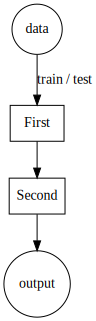

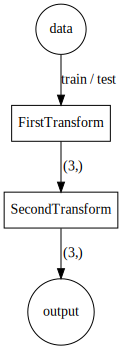

In [42]:
tst.run (test_construct_diagram, tag='dummy')

#### show_summary

In [43]:
# exports tests.core.test_compose
#@pytest.mark.reference_fails
def test_show_summary ():
    path_results = 'show_summary'
    remove_previous_results (path_results=path_results)

    pipeline = build_pipeline_construct_diagram_2 (path_results)
    X = np.array([1,2,3])
    result = pipeline (X)

    pipeline.show_summary ()
    
    remove_previous_results (path_results=path_results)

In [44]:
tst.run (test_show_summary, tag='dummy', do=True)

running test_show_summary
----------------------------------------------------------------------------------------------------
0: FirstTransform =>  (3,)
----------------------------------------------------------------------------------------------------
1: SecondTransform =>  (3,)


## make_pipeline function

In [45]:
# export
def make_pipeline(*components, cls=Pipeline, **kwargs):
    """Create `Pipeline` object of class `cls`, given `components` list."""
    pipeline = cls (**kwargs)
    pipeline.set_components(*components)
    return pipeline

### Usage example

In [46]:
# exports tests.core.test_compose
#@pytest.mark.reference_fails
def test_make_pipeline ():
    tr1 = Component(FunctionTransformer (lambda x: x+1))
    tr2 = Component(FunctionTransformer (lambda x: x*2))
    pipeline = make_pipeline (tr1, tr2)
    result = pipeline.transform (3)

    print (result)
    assert result == 8

In [47]:
tst.run (test_make_pipeline, tag='dummy')

running test_make_pipeline
8


## pipeline_factory

In [48]:
# export
def pipeline_factory (pipeline_class, **kwargs):
    """Creates a pipeline object given its class `pipeline_class`
    
    Parameters
    ----------
    pipeline_class : class or str
        Name of the pipeline class used for creating the object. 
        This can be either of type string or class.
    """
    if type(pipeline_class) is str:
        Pipeline = eval(pipeline_class)
    elif type(pipeline_class) is type:
        Pipeline = pipeline_class
    else:
        raise ValueError (f'pipeline_class needs to be either string or class, we got {pipeline_class}')

    return Pipeline (**kwargs)

### Usage example

In [49]:
# exports tests.core.test_compose
#@pytest.mark.reference_fails
def test_pipeline_factory ():
    path_results = 'pipeline_factory'
    remove_previous_results (path_results=path_results)

    pipeline1 = pipeline_factory (SimplePipeline, path_results=path_results)
    assert pipeline1.path_results==Path(path_results).resolve()
    #pipeline2 = pipeline_factory ('SimplePipeline', path_results=path_results)
    #assert pipeline2.path_results==Path(path_results).resolve()

    remove_previous_results (path_results=path_results)

In [50]:
tst.run (test_pipeline_factory, tag='dummy')

running test_pipeline_factory


## PandasPipeline

In [51]:
#export
class PandasPipeline (Pipeline):
    """
    Pipeline that saves results in parquet format, and preserves DataFrame format.
    
    See `Pipeline` class for an explanation of using `separate_labels=False`
    """
    def __init__ (self, 
                  data_converter='PandasConverter',
                  data_io='PandasIO',
                  separate_labels=False,
                  **kwargs):
        super().__init__ (data_converter=data_converter,
                          data_io=data_io,
                          separate_labels=separate_labels,
                          **kwargs)

### Usage example

In [52]:
# exports tests.core.test_compose
# **********************************************
# Good example
# **********************************************
class PandasTransformWithLabels1 (PandasComponent):

    def __init__ (self, **kwargs):
        super().__init__ (**kwargs)
        self.estimator= Bunch(sum = 1)

    def _fit (self, X, y=None):
        self.estimator.sum = X[y==1].sum(axis=0)

    def _apply (self, X):
        r = X*1000 + self.estimator.sum
        return r
    
class PandasTransformWithLabels2 (PandasComponent):

    def __init__ (self, **kwargs):
        super().__init__ (**kwargs)
        self.estimator= Bunch(maxim = 1)

    def _fit (self, X, y=None):
        self.estimator.maxim = X[y==0].max(axis=0)

    def _apply (self, X):
        r = X*100 + self.estimator.maxim
        return r
            
class SimplePandasPipeline (PandasPipeline):
    def __init__ (self, **kwargs):
        super().__init__ (**kwargs)

        # custom transform
        self.tr1 = PandasTransformWithLabels1(**kwargs) 

        # slklearn transform
        self.tr2 = PandasTransformWithLabels2(**kwargs)
        
# **********************************************
# Bad example
# **********************************************
class TransformWithLabels1 (Component):

    def __init__ (self, **kwargs):
        super().__init__ (**kwargs)
        self.estimator= Bunch(sum = 1)

    def _fit (self, X, y=None):
        self.estimator.sum = X[y==1].sum(axis=0)

    def _apply (self, x):
        return x*1000 + self.estimator.sum

class TransformWithLabels2 (Component):

    def __init__ (self, **kwargs):
        super().__init__ (**kwargs)
        self.estimator= Bunch(maxim = 1)

    def _fit (self, X, y=None):
        self.estimator.maxim = X[y==0].max(axis=0)

    def _apply (self, x):
        return x*100 + self.estimator.maxim
    

class SimplePandasPipelineNoPandasComponent (PandasPipeline):
    def __init__ (self, **kwargs):
        super().__init__ (**kwargs)

        # custom transform
        self.tr1 = TransformWithLabels1(**kwargs) 

        # slklearn transform
        self.tr2 = TransformWithLabels2(**kwargs)


In [53]:
# exports tests.core.test_compose
#@pytest.mark.reference_fails
def test_pandas_pipeline ():
    path_results = 'pandas_pipeline'
    remove_previous_results (path_results=path_results)
    df = pd.DataFrame ({'a':[1,2,3,4], 'b': [5,6,7,8], 'label': [1,0,1,0]})

    pipe = SimplePandasPipelineNoPandasComponent ()
    with pytest.raises (KeyError):
        r = pipe.fit_transform (df)
        display (r)

    pipe = SimplePandasPipeline ()
    r = pipe.fit_transform (df)
    display (r)

    tr1 = PandasTransformWithLabels1 ()
    tr2 = PandasTransformWithLabels2 ()
    r1=tr1.fit_transform (df)
    r2=tr2.fit_transform (r1)
    assert (r==r2).all().all()

    df_equal = (r1==df*1000+df[df.label==1].sum(axis=0))[['a','b']]
    assert df_equal.all().all()

    df_equal = (r2==r1*100+r1[r1.label==0].max(axis=0))[['a','b']]
    assert df_equal.all().all()
    remove_previous_results (path_results=path_results)

In [54]:
tst.run (test_pandas_pipeline, tag='dummy')

running test_pandas_pipeline


,a,b,label
0,104404,509212,1
1,204404,609212,0
2,304404,709212,1
3,404404,809212,0


## Parallel

In [55]:
#export
class Parallel (MultiComponent):
    """
    List of components that don't have sequential dependencies.
    
    As the name suggests, these components could run in parallel,
    if a concurrency mechanism is employed.
    """
    def __init__ (self, *components, select_data_before_fitting=None, select_data_before_transforming=None, 
                  initialize_result=None, join_result=None, **kwargs):
        """Assigns attributes and calls parent constructor.
        """
        
        select_data_before_fitting = (self.select_data_before_fitting if select_data_before_fitting is None
                                      else select_data_before_fitting)
        self.select_data_before_fitting = select_data_before_fitting
        select_data_before_transforming = (self.select_data_before_transforming 
                                           if select_data_before_transforming is None
                                           else select_data_before_transforming)
        self.select_data_before_transforming = select_data_before_transforming
        initialize_result = (self.initialize_result if initialize_result is None
                                      else initialize_result)
        self.initialize_result = initialize_result
        join_result = (self.join_result if join_result is None
                                      else join_result)
        self.join_result = join_result
        
        super().__init__ (*components, **kwargs)
        
    def select_data_before_fitting (self, X, y, components, i):
        return X, y
    
    def _fit (self, X, y=None):
        """
        Fit components of the pipeline, given data X and labels y.
        
        By default, y will be None, and the labels are part of `X`, as a variable.
        """
        for i, component in enumerate(self.components):
            Xi, yi = self.select_data_before_fitting (X, y, self.components, i)
            component.fit (Xi, yi, **kwargs)
        
    def initialize_result (self):
        return []
    
    def select_data_before_transforming (self, X, components, i):
        return X
    
    def join_result (self, Xr, Xi_r, components, i):
        Xr.append (Xi_r)
        return Xr
    
    def _apply (self, X):
        """Transform data with components of pipeline, and predict labels with last component. 
        
        In the current implementation, we consider prediction a form of mapping, 
        and therefore a special type of transformation."""
        Xr = self.initialize_result ()
        for i, component in enumerate(self.components):
            Xi = self.select_data_before_transforming (X, self.components, i)
            Xi_r = component.transform (Xi)
            Xr = self.join_result (Xr, Xi_r, self.components, i)

        return Xr
    
    def _fit_apply (self, X, y=None, **kwargs):
        Xr = self.initialize_result ()
        for i, component in enumerate(self.components):
            Xi, yi = self.select_data_before_fitting (X, y, self.components, i)
            Xi_r = component.fit_apply (Xi, yi, **kwargs)
            Xr = self.join_result (Xr, Xi_r, self.components, i)
        
        return Xr
    
    def find_last_result (self, split=None):
        self.is_data_source = True
        for i, component in self.components:
            if not (component.data_io.can_load_result () and component.data_io.exists_result (split=split)):
                if isinstance (component, MultiComponent):
                    self.is_data_source = self.is_data_source and component.find_last_result (split=split)
                else:
                    self.is_data_source = False
        return self.is_data_source

### Usage example

In [56]:
# exports tests.core.test_compose
#@pytest.mark.reference_fails
def test_parallel ():
    x = np.array([3,4,5]).reshape(-1,1)
    parallel = Parallel (Transform1 (),
                         Transform2 ())
    r1 = parallel.fit_apply (x)

    x1 = x * 1000 + x.sum(axis=0)
    x2 = x * 100 + x.max(axis=0)
    r_ref = [x1, x2]
    assert all([(x==y).all() for x, y in zip(r1, r_ref)])

    parallel = Parallel (Transform1 (),
                         Transform2 (),
                         initialize_result=lambda : {},
                         join_result=lambda Xr, Xi_r, components, i: {**Xr, **{components[i].name:Xi_r}})

    r1 = parallel.fit_apply (x)
    assert list(r1.keys())==['transform1','transform2']
    assert (r1['transform1']==r_ref[0]).all()
    assert (r1['transform2']==r_ref[1]).all()

In [57]:
tst.run (test_parallel, tag='dummy')

running test_parallel


## MultiModality

In [72]:
#export
class MultiModality (Parallel):
    """
    Analyzes multiple modalities using Parallel data flow.
    """
    def __init__ (self, *components, use_name=False, component_class=None, configs=None, **kwargs):
        """Assigns attributes and calls parent constructor.
        """
        
        if component_class is not None and configs is not None and isinstance(configs, dict):
            new_components = []
            for k in configs:
                new_components.append (component_class (**configs[k], folder=k, suffix=k))
            components = list(components) + new_components
        super().__init__ (*components, **kwargs)
        for component in components:
            component.key = component.name if use_name else component.data_io.folder
        
    def select_data_before_fitting (self, X, y, components, i):
        return X[components[i].key], y
           
    def initialize_result (self):
        return {component.key: None for component in self.components}
    
    def select_data_before_transforming (self, X, components, i):
        return X[components[i].key]
    
    def join_result (self, Xr, Xi_r, components, i):
        Xr[components[i].key] = Xi_r
        return Xr

### Usage example

In [93]:
# exports tests.core.test_compose
#@pytest.mark.reference_fails
class TransformM (Component):

    def __init__ (self, modality='', factor=1000, **kwargs):
        super().__init__ (**kwargs)
        self.estimator= Bunch(sum = 1)

    def _fit (self, X, y=None):
        self.estimator.sum = X.sum(axis=0)

    def _apply (self, x):
        return x*self.factor + self.estimator.sum
    
def test_multi_modality ():
    data = {'transform1': np.array([1,2,3]),
            'transform2': np.array([10,20,30])}
    
    parallel = MultiModality (Transform1 (),
                              Transform2 (),
                              use_name=True)
    r = parallel.fit_apply (data)

    x1 = data['transform1']
    x1 = x1 * 1000 + x1.sum(axis=0)
    x2 = data['transform2']
    x2 = x2 * 100 + x2.max(axis=0)
    assert list(r.keys())==['transform1','transform2']
    assert (r['transform1']==x1).all()
    assert (r['transform2']==x2).all()
    
    # with configs
    data = dict(modA=np.array([1,2,3]),
                modB=np.array([10,20,30]))
    configs = dict(modA=dict (modality='A', factor=2000),
                   modB=dict (modality='B', factor=3000))

    parallel = MultiModality (component_class=TransformM,
                              configs=configs)
    r = parallel.fit_apply (data)

    x1 = data['modA']
    x1 = x1 * 2000 + x1.sum(axis=0)
    x2 = data['modB']
    x2 = x2 * 3000 + x2.sum(axis=0)
    assert list(r.keys())==['modA','modB']
    assert (r['modA']==x1).all()
    assert (r['modB']==x2).all()

    assert parallel.transform_m_modA.modality == 'A'
    assert parallel.transform_m_modB.modality == 'B'

In [94]:
tst.run (test_multi_modality, tag='dummy')

running test_multi_modality


## ColumnTransformer

### ColumnSelector

In [51]:
#export
class ColumnSelector (NoSaverComponent):
    def __init__ (self, 
                  columns=[],
                  remainder=False,
                  verbose=dflt.verbose,
                  force_verbose=False,
                  logger=None,
                  **kwargs):
        verbose = 0 if not force_verbose else verbose
        if verbose==0:
            logger = set_empty_logger ()
        super().__init__ (verbose=verbose,
                          logger=logger,
                          **kwargs)
    
    def _apply (self, df):
        if self.remainder:
            return df[[c for c in df.columns if c not in self.columns]]
        else:
            return df[self.columns]

#### example usage

In [52]:
# exports tests.core.test_compose
#@pytest.mark.reference_fails
def test_column_selector ():
    df = pd.DataFrame ({'x1': list(range(5)),
                    'x2': list(range(5,10)),
                    'x3': list(range(15,20)),
                    'x4': list(range(25,30))
                   })
    dfr = ColumnSelector(columns=['x2','x4']).transform(df)
    assert (dfr==df[['x2','x4']]).all().all()

In [53]:
tst.run (test_column_selector, tag='dummy')

running test_column_selector


### Concat

In [54]:
#export
class Concat (NoSaverComponent):
    def __init__ (self, 
                  verbose=dflt.verbose,
                  force_verbose=False,
                  logger=None,
                  **kwargs):
        verbose = 0 if not force_verbose else verbose
        if verbose==0:
            logger = set_empty_logger ()
        super().__init__ (verbose=verbose,
                          logger=logger,
                          **kwargs)
        
    def _apply (self, *dfs):
        return pd.concat(list(dfs), axis=1)

### ColumnTransformer

In [55]:
# export
class _BaseColumnTransformer (MultiComponent):
    def __init__ (self, name=None, class_name=None, **kwargs):
        super().__init__ (name=name, class_name=class_name, **kwargs)
        self.concat = Concat (**kwargs)
        del self.concat.nick_name
    
    def set_components (self, *components):
        components = list(components)
        components.append (self.concat)
        super().set_components (*components)
    
    def _fit (self, df, y=None):
        assert len(self.components) > 0
        assert self.components[-1] is self.concat
        for component in self.components[:-1]:
            component.fit (df)
        return self
    
    def _apply (self, df):
        dfs = []
        assert len(self.components) > 0
        assert self.components[-1] is self.concat
        for component in self.components[:-1]:
            dfs.append (component.transform (df))
        df_result = self.concat.transform (*dfs)
        return df_result
    
class ColumnTransformer (_BaseColumnTransformer):
    def __init__ (self, *transformers, remainder = 'drop', **kwargs):
        super().__init__ (**kwargs)
        components = make_column_transformer_pipelines (*transformers, remainder=remainder, **kwargs)
        super().set_components(*components)

### Identity

In [56]:
# export
class Identity (NoSaverComponent):
    def __init__ (self,           
                  verbose=dflt.verbose,
                  force_verbose=False,
                  logger=None,
                  **kwargs):
        verbose = 0 if not force_verbose else verbose
        if verbose==0:
            logger = set_empty_logger ()
        super().__init__ (verbose=verbose,
                          logger=logger,
                          **kwargs)
        
    def _apply (self, X):
        return X

### make_column_transformer

In [57]:
# export
def _append_pipeline (pipelines, name, transformer, columns, remainder= False, **kwargs):
    drop = False
    if isinstance(transformer, str):
        if transformer == 'passthrough':
            transformer = Identity (**kwargs)
        elif transformer == 'drop':
            drop = True
        else:
            raise ValueError (f'name {transformer} not recognized')
    
    if not drop:
        config=kwargs.copy()
        config.update({name:dict(data_io='NoSaverIO')})
        pipeline = make_pipeline(ColumnSelector(columns, remainder=remainder, **kwargs), 
                                 transformer, 
                                 name=name,
                                 **config)
        pipelines.append (pipeline)

def _get_transformer_name (transformer, columns):
    columns_name = ''.join([x[0] for x in columns])
    if len(columns_name) > 5:
        columns_name = columns_name[:5]
    if isinstance(transformer,str): 
        if transformer == 'passthrough':
            transformer_name = 'pass'
        elif transformer == 'drop':
            transformer_name = 'drop'
        else:
            raise ValueError (f'name {transformer} not recognized')
    elif hasattr(transformer, 'name'):
        transformer_name = transformer.name
    else:
        transformer_name = transformer.__class__.__name__
    name = f'{transformer_name}_{columns_name}'
    return name
        
def make_column_transformer_pipelines (*transformers, remainder='drop', **kwargs):
    pipelines = []
    all_columns = []
    for name, transformer, columns in transformers:
        _append_pipeline (pipelines, name, transformer, columns, **kwargs)
        all_columns.extend(columns)
    
    all_columns = list(set(all_columns))
    name = _get_transformer_name (remainder, ['r','e','m'])
    _append_pipeline (pipelines, name, remainder, all_columns, remainder=True, **kwargs)
        
    return pipelines

def make_column_transformer (*transformers, remainder='drop', name=None, class_name=None, **kwargs):
    transformers_with_name = []
    for transformer, columns in transformers:
        transformer_name = _get_transformer_name (transformer, columns)
        transformers_with_name.append ((transformer_name, transformer, columns))
    
    pipelines = make_column_transformer_pipelines (*transformers_with_name, 
                                                   remainder=remainder, 
                                                   **kwargs)
    column_transformer = _BaseColumnTransformer (name=name, class_name=class_name, **kwargs)
    column_transformer.set_components(*pipelines)
    return column_transformer
    

#### Simple example

In [58]:
# exports tests.core.test_compose
def column_transformer_data ():
    df = pd.DataFrame ({'cont1': list(range(5)),
                        'cont2': list(range(5,10)),
                        'cont3': list(range(15,20)),
                        'cont4': list(range(25,30)),
                        'cat_1': list([1,2,3,2,1]),
                        'cat_2': list([0,1,1,0,0])
                        })
        
    tr1 = Component(FunctionTransformer (lambda x: x+1), name='tr1')
    
    return df, tr1
        
#@pytest.mark.reference_fails
def test_make_column_transformer (column_transformer_data):

    df, tr1 = column_transformer_data

    tr1 = Component(FunctionTransformer (lambda x: x+1), name='tr1')
    tr2 = PandasComponent(FunctionTransformer (lambda x: x*2), transformed_columns=['cont2_bis','cat_1'], name='tr2')

    column_transformer = make_column_transformer (
        (tr1, ['cont2', 'cont4']),
        (tr2, ['cont2', 'cat_1'])
    )
    dfr = column_transformer.transform(df)

    # display and test
    display(dfr)
    assert (dfr[['cont2','cont4']] == tr1(df[['cont2','cont4']])).all().all()
    assert (dfr[['cont2_bis','cat_1']] == tr2(df[['cont2','cat_1']])).all().all()
    assert (dfr.columns == ['cont2','cont4', 'cont2_bis','cat_1']).all()
    assert (column_transformer.name, column_transformer.class_name) == ('__base_column_transformer', '_BaseColumnTransformer')

    # set name of column transformer
    column_transformer = make_column_transformer (
        (tr1, ['cont2', 'cont4']),
        (tr2, ['cont2', 'cat_1']),
        name='test_transformer',
        class_name='TestTransformer'
    )
    assert (column_transformer.name, column_transformer.class_name) == ('test_transformer', 'TestTransformer')

    # set name of column transformer and parameters that are specific 
    # for the column_transformer: path_results
    column_transformer = make_column_transformer (
        (tr1, ['cont2', 'cont4']),
        (tr2, ['cont2', 'cat_1']),
        name='test_transformer',
        class_name='TestTransformer',
        TestTransformer=dict(path_results='mine'),
        path_results='other'
    )
    assert column_transformer.path_results.name=='mine'
    assert column_transformer.components[0].path_results.name=='other'

In [59]:
tst.run (test_make_column_transformer, column_transformer_data, tag='dummy')

running test_make_column_transformer


,cont2,cont4,cont2_bis,cat_1
0,6,26,10,2
1,7,27,12,4
2,8,28,14,6
3,9,29,16,4
4,10,30,18,2


#### Using `passthrough`

In [60]:
# exports tests.core.test_compose
#@pytest.mark.reference_fails
def test_make_column_transformer_passthrough (column_transformer_data):
    df, tr1 = column_transformer_data
    
    column_transformer = make_column_transformer (
        (tr1, ['cont1', 'cont4']),
        ('passthrough', ['cont2', 'cat_1'])
    )
    dfr = column_transformer.transform(df)

    # display and test
    display(dfr)
    assert (dfr[['cont1','cont4']] == tr1(df[['cont1','cont4']])).all().all()
    assert (dfr[['cont2','cat_1']] == df[['cont2','cat_1']]).all().all()
    assert (dfr.columns == ['cont1','cont4', 'cont2','cat_1']).all()

In [61]:
tst.run (test_make_column_transformer_passthrough, column_transformer_data, tag='dummy')

running test_make_column_transformer_passthrough


,cont1,cont4,cont2,cat_1
0,1,26,5,1
1,2,27,6,2
2,3,28,7,3
3,4,29,8,2
4,5,30,9,1


#### Using remainder

In [62]:
# exports tests.core.test_compose
#@pytest.mark.reference_fails
def test_make_column_transformer_remainder (column_transformer_data):
    
    df, tr1 = column_transformer_data
    
    # remainder is new transformation
    tr3 = Component(FunctionTransformer (lambda x: x+100), name='tr3')
    column_transformer = make_column_transformer (
        (tr1, ['cont1', 'cont4']),
        ('passthrough', ['cont2', 'cat_1']),
        remainder=tr3
    )
    dfr = column_transformer.transform(df)

    # display and test
    display('with tr3', dfr)
    assert (dfr[['cont1','cont4']] == tr1(df[['cont1','cont4']])).all().all()
    assert (dfr[['cont2','cat_1']] == df[['cont2','cat_1']]).all().all()
    assert (dfr[['cont3','cat_2']] == tr3(df[['cont3','cat_2']])).all().all()
    assert (dfr.columns == ['cont1','cont4', 'cont2','cat_1','cont3','cat_2']).all()

    # remainder is passthrough
    del tr1.nick_name
    del tr3.nick_name
    column_transformer = make_column_transformer (
        (tr1, ['cont1', 'cont4']),
        (tr3, ['cont2', 'cat_1']),
        remainder='passthrough'
    )
    dfr = column_transformer.transform(df)

    display('with passthrough', dfr)
    assert (dfr[['cont1','cont4']] == tr1(df[['cont1','cont4']])).all().all()
    assert (dfr[['cont2','cat_1']] == tr3(df[['cont2','cat_1']])).all().all()
    assert (dfr[['cont3','cat_2']] == df[['cont3','cat_2']]).all().all()
    assert (dfr.columns == ['cont1','cont4', 'cont2','cat_1','cont3','cat_2']).all()

    # remainder is tr3, and one of the transforms is drop
    del tr1.nick_name
    del tr3.nick_name
    column_transformer = make_column_transformer (
        (tr1, ['cont1', 'cont4']),
        ('drop', ['cont2', 'cat_1']),
        remainder=tr3
    )
    dfr = column_transformer.transform(df)

    display('with drop one of the transforms - cont2, cat_1', dfr)
    assert (dfr[['cont1','cont4']] == tr1(df[['cont1','cont4']])).all().all()
    assert (dfr[['cont3','cat_2']] == tr3(df[['cont3','cat_2']])).all().all()
    assert (dfr.columns == ['cont1','cont4', 'cont3','cat_2']).all()
    
    # check gather_descendants
    column_transformer.gather_descendants()
    assert sorted(column_transformer.full_obj.keys())==['column_selector', 'concat', 'tr1', 'tr1_cc', 'tr3', 'tr3_rem']

In [63]:
tst.run (test_make_column_transformer_remainder, column_transformer_data, tag='dummy')

running test_make_column_transformer_remainder


'with tr3'

,cont1,cont4,cont2,cat_1,cont3,cat_2
0,1,26,5,1,115,100
1,2,27,6,2,116,101
2,3,28,7,3,117,101
3,4,29,8,2,118,100
4,5,30,9,1,119,100


'with passthrough'

,cont1,cont4,cont2,cat_1,cont3,cat_2
0,1,26,105,101,15,0
1,2,27,106,102,16,1
2,3,28,107,103,17,1
3,4,29,108,102,18,0
4,5,30,109,101,19,0


'with drop one of the transforms - cont2, cat_1'

,cont1,cont4,cont3,cat_2
0,1,26,115,100
1,2,27,116,101
2,3,28,117,101
3,4,29,118,100
4,5,30,119,100


#### gather_descendants

In [64]:
# exports tests.core.test_compose
#@pytest.mark.reference_fails
def test_make_column_transformer_descendants (column_transformer_data):
    
    df, tr1 = column_transformer_data
    
    tr3 = Component(FunctionTransformer (lambda x: x+100), name='tr3')
    
    column_transformer = make_column_transformer (
        (tr1, ['cont1', 'cont4']),
        ('drop', ['cont2', 'cat_1']),
        remainder=tr3
    )
    
    # check gather_descendants
    column_transformer.gather_descendants()
    assert sorted(column_transformer.full_obj.keys())==['column_selector', 'concat', 'tr1', 'tr1_cc', 'tr3', 'tr3_rem']

In [65]:
tst.run (test_make_column_transformer_descendants, column_transformer_data, tag='dummy')

running test_make_column_transformer_descendants


#### Example using `fit_transform`

In [66]:
# exports tests.core.test_compose
#@pytest.mark.reference_fails
def test_make_column_transformer_fit_transform (column_transformer_data):
    
    df, tr1 = column_transformer_data
    
    class SumTimes100 (Component):
        def _fit (self, X, y=None):
            self.sum = X.sum(axis=0)
        def _apply (self, X):

            dfr = pd.DataFrame ({'c1_times100': self.sum.values[0]*100 + X.iloc[:,0].values,
                                 'c2_times100': self.sum.values[1]*100 + X.iloc[:,1].values,
                                 'c2_times1000': self.sum.values[1]*1000 + X.iloc[:,1].values})
            return dfr

    tr1 = SumTimes100 ()
    tr2 = PandasComponent(FunctionTransformer (lambda x: x*2), name='tr2')

    column_transformer = make_column_transformer (
        (tr1, ['cont2', 'cont4']),
        (tr2, ['cont2', 'cat_1'])
    )
    dfr = column_transformer.fit_transform(df)

    # display & test
    display(dfr)
    assert (dfr.columns == ['c1_times100','c2_times100', 'c2_times1000','cont2', 'cat_1']).all()
    assert (dfr['c1_times100'] == sum(df.cont2)*100+df.cont2).all()
    assert (dfr['c2_times100'] == sum(df.cont4)*100+df.cont4).all()
    assert (dfr['c2_times1000'] == sum(df.cont4)*1000+df.cont4).all()

In [67]:
tst.run (test_make_column_transformer_fit_transform, column_transformer_data, tag='dummy')

running test_make_column_transformer_fit_transform


,c1_times100,c2_times100,c2_times1000,cont2,cat_1
0,3505,13525,135025,10,2
1,3506,13526,135026,12,4
2,3507,13527,135027,14,6
3,3508,13528,135028,16,4
4,3509,13529,135029,18,2


## MultiSplitComponent

In [68]:
#export
class MultiSplitComponent (MultiComponent):
    def __init__ (self, 
                  component=None, 
                  name=None,
                  class_name=None,
                  fit_to = 'training',
                  fit_additional = [],
                  apply_to = ['training', 'validation', 'test'],
                  raise_error_if_split_doesnot_exist=False,
                  raise_warning_if_split_doesnot_exist=True,
                  **kwargs):
        if class_name is None:
            if hasattr(component, 'class_name'):
                class_name = f'{component.class_name}MultiSplit'
            else:
                class_name = f'{component.__class__.__name__}MultiSplit'

        if name is None:
            if hasattr(component, 'name'):
                name = f'{component.name}_multi_split'
            else:
                name = f'{component.__class__.__name__}_multi_split'

        super().__init__ (name=name, class_name=class_name, **kwargs)
    
    def _fit (self, X, y=None):
        if not isinstance(X, dict):
            X = {self.fit_to: X}
        component = self.components[0]
        additional_data = {}
        for split in self.fit_additional:
            if split not in ['validation', 'test']:
                raise ValueError (f'split {split} not valid')
            if split in X.keys():
                additional_data[f'{split}_data'] = X[split]
            else:
                self._issue_error_or_warning (split, X)
        
        component.fit(X[self.fit_to], y=y, split='training', **additional_data)
    
    def _issue_error_or_warning (self, split, X):
        message = f'split {split} not found in X keys ({X.keys()})'
        if self.raise_error_if_split_doesnot_exist:
            raise RuntimeError (message)
        elif self.raise_warning_if_split_doesnot_exist:
            warnings.warn (message)
    
    def _apply (self, X, apply_to = None, output_not_dict=False, split=None, **kwargs):
        apply_to = self.apply_to if apply_to is None else apply_to
        apply_to = apply_to if isinstance(apply_to, list) else [apply_to]
        if not isinstance(X, dict):
            key = apply_to[0] if len(apply_to)==1 else split if split is not None else 'test'
            X = {key: X}
            input_not_dict = True
        else:
            input_not_dict = False
            
        component = self.components[0]
        result = {}
        for split in apply_to:
            if split in X.keys():
                result[split] = component.apply (X[split], split=split, **kwargs)
            else:
                self._issue_error_or_warning (split, X)
        
        if input_not_dict:
            result = result[key]
        elif output_not_dict and len(result)==1:
            result = list(result.items())[0][1]
        return result
        
    def find_last_result (self, apply_to = None, split=None, **kwargs):
        apply_to = self.apply_to if apply_to is None else apply_to
        apply_to = apply_to if isinstance(apply_to, list) else [apply_to]

        self.is_data_source = True
        for split in apply_to:
            if not (component.data_io.can_load_result () and component.data_io.exists_result (split=split)):
                if isinstance (component, MultiComponent):
                    # TODO: have one flag is_data_source per split
                    # or make MultiSplitComponent a Parallel object
                    # or always use DataFrame
                    self.is_data_source = self.is_data_source and component.find_last_result (split=split)
                else:
                    self.is_data_source = False
        return self.is_data_source
            

### Tests / usage examples

#### apply transform on multiple splits

In [69]:
# exports tests.core.test_compose
class Transform1 (Component):
    def __init__ (self, **kwargs):
        super().__init__ (**kwargs)
        self.estimator= Bunch(sum = 1)

    def _fit (self, X, y=None):
        self.estimator.sum = X.sum(axis=0)

    def _apply (self, x):
        return x*1000 + self.estimator.sum
    
class Transform2 (Component):
    def __init__ (self, **kwargs):
        super().__init__ (**kwargs)
        self.estimator= Bunch(maxim = 1)

    def _fit (self, X, y=None, validation_data=None, test_data=None):
        self.estimator.maxim = X.max(axis=0)

        print (f'validation_data: {validation_data}')
        print (f'test_data: {test_data}')

        self.data = dict (validation=validation_data,
                          test=test_data)

    def _apply (self, x):
        return x*100 + self.estimator.maxim

def multi_split_data ():
    data = dict(training = np.array([1,2,3]).reshape(-1,1),
            validation = np.array([10,20,30]).reshape(-1,1),
            test = np.array([100,200,300]).reshape(-1,1)
            )
    
    multi_transform1 = MultiSplitComponent (component = Transform1())
    
    tr2 = Transform2()
    multi_transform2 = MultiSplitComponent (component=tr2,
                                            fit_additional = ['validation', 'test'])
    
    return data, multi_transform1, multi_transform2, tr2

#@pytest.mark.reference_fails
def test_multi_split_transform (multi_split_data):
    # example 1: apply transform on multiple splits
    data, multi_transform1, multi_transform2, tr2 = multi_split_data
    
    result = multi_transform1.fit_transform (data)

    assert type(result) is dict
    assert result.keys() == data.keys()
    for split in result.keys():
        assert (result[split]==sum(data['training'].ravel())+data[split]*1000).all()

    # check that automatic name given is based on component
    assert multi_transform1.name=='transform1_multi_split'
    assert multi_transform1.class_name=='Transform1MultiSplit'

    # check that we can assign a different name
    multi_transform1 = MultiSplitComponent (component = Transform1(), name='different', class_name='Yes')
    assert multi_transform1.name=='different'
    assert multi_transform1.class_name=='Yes'
    # check that this new name is given only to MultiSplitComponent, 
    # not to the component that it's wrapping
    assert multi_transform1.component.name=='transform1'
    assert multi_transform1.component.class_name=='Transform1'

In [70]:
tst.run (test_multi_split_transform, multi_split_data, tag='dummy')

running test_multi_split_transform


#### fit method gets training, validation and test

In [71]:
# exports tests.core.test_compose
#@pytest.mark.reference_fails
def test_multi_split_fit (multi_split_data):
    # example 2: fit method gets training, validation and test
    data, multi_transform1, multi_transform2, tr2 = multi_split_data
    # we apply the transform to only test
    

    # we apply the transform to only test data
    result = multi_transform2.fit_transform (data, apply_to='test')

    assert type(result) is dict
    assert list(result.keys()) == ['test']
    for split in result.keys():
        assert (result[split]==max(data['training'].ravel())+data[split]*100).all()

    for split in ['validation', 'test']:
        assert (tr2.data[split] == data[split]).all()

In [72]:
tst.run (test_multi_split_fit, multi_split_data, tag='dummy')

running test_multi_split_fit
validation_data: [[10]
 [20]
 [30]]
test_data: [[100]
 [200]
 [300]]


#### chain transformations

In [73]:
# exports tests.core.test_compose
#@pytest.mark.reference_fails
def test_multi_split_chain (multi_split_data):
    data, multi_transform1, multi_transform2, tr2 = multi_split_data
    
    # test that we can chain transformations

    result = multi_transform1.fit_transform (data)
    result = multi_transform2.fit_transform (result, apply_to='test')

    import pytest 

    #check that we have no error if split does not exist
    result = multi_transform1.fit_transform (data, apply_to=['training', 'validation'])
    result = multi_transform2.fit_transform (result, apply_to=['test'])
    assert len(result)==0

    #check that we have an error if we set the flag `raise_error_if_split_doesnot_exist=True`
    multi_transform2.raise_error_if_split_doesnot_exist = True
    result = multi_transform1.fit_transform (data, apply_to=['training', 'validation'])
    with pytest.raises (RuntimeError):
        result = multi_transform2.fit_transform (result, apply_to=['test'])

In [74]:
tst.run (test_multi_split_chain, multi_split_data, tag='dummy')

running test_multi_split_chain
validation_data: [[10006]
 [20006]
 [30006]]
test_data: [[100006]
 [200006]
 [300006]]
validation_data: [[10006]
 [20006]
 [30006]]
test_data: None


#### loading / saving

In [75]:
# exports tests.core.test_compose
#@pytest.mark.reference_fails
def test_multi_split_io (multi_split_data):
    
    data, multi_transform1, multi_transform2, tr2 = multi_split_data
    
    # check loading / saving
    from block_types.utils.utils import remove_previous_results
    from block_types.core.utils import PickleIO

    path_results = 'results_multi_split'

    remove_previous_results (path_results=path_results)

    tr = PickleSaverComponent (FunctionTransformer (lambda x: x*2),
                    name='times2',
                    path_results=path_results)

    multi_transform = MultiSplitComponent (component=tr,
                                           apply_to = ['validation', 'test'],
                                           path_results = path_results,
                                           data_io=PickleIO (path_results = path_results))

    result = multi_transform (data)

    multi_transform2 = MultiSplitComponent (data_io=PickleIO (path_results = path_results), name='times2_multi_split')

    result2 = multi_transform2.data_io.load_result ()

    for k in result.keys():
        assert (result[k] == result2[k]).all()

    assert result.keys()==result2.keys()

    assert sorted(os.listdir(path_results))==['test', 'validation', 'whole']

    assert (tr.data_io.load_result(split='test') == result['test']).all()

    assert (tr.data_io.load_result(split='validation') == result['validation']).all()

    assert os.listdir(f'{path_results}/validation')==['times2_result.pk']

    assert os.listdir(f'{path_results}/test')==['times2_result.pk']

    assert os.listdir(f'{path_results}/whole')==['times2_multi_split_result.pk']

    remove_previous_results (path_results=path_results)

In [76]:
tst.run (test_multi_split_io, multi_split_data, tag='dummy')

running test_multi_split_io


### With non-dictionary input / output

In [77]:
# exports tests.core.test_compose
#@pytest.mark.reference_fails
def test_multi_split_non_dict ():
    # check loading / saving
    tr = Component (FunctionTransformer (lambda x: x*2))

    multi_transform = MultiSplitComponent (tr, apply_to = ['test'])

    data = np.array([100,200,300]).reshape(-1,1)
    result = multi_transform (data)

    assert type(result)==np.ndarray
    assert (result==data*2).all()

In [78]:
tst.run (test_multi_split_non_dict, tag='dummy')

running test_multi_split_non_dict


output applied to single split, converted to non-dictionary

In [79]:
# exports tests.core.test_compose
#@pytest.mark.reference_fails
def test_multi_split_non_dict_bis ():
    tr = Component (FunctionTransformer (lambda x: x*2))

    multi_transform = MultiSplitComponent (tr, apply_to = ['test'])
    
    # output applied to single split, converted to non-dictionary
    data = dict(training = np.array([1,2,3]).reshape(-1,1),
                validation = np.array([10,20,30]).reshape(-1,1),
                test = np.array([100,200,300]).reshape(-1,1))
    result = multi_transform (data, output_not_dict=True)

    assert type(result)==np.ndarray
    assert (result==data['test']*2).all()

In [80]:
tst.run (test_multi_split_non_dict_bis, tag='dummy')

running test_multi_split_non_dict_bis
